In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
def sample(x):
    x_shape = x.shape
    x = x + np.random.randn(*x.shape)
    x = np.reshape(x, (np.prod(x_shape),))
    idx = np.arange(x_shape[0])*x_shape[1] + \
        np.random.choice(np.arange(x_shape[1]), size=x_shape[0])
    return x[idx]

In [3]:
X_train = np.random.rand(1000000,4)*100
Y_train = sample(X_train)

In [4]:
def quantile_loss(y_true, y_pred):
    n_quantile = int(y_pred.shape[-1])
    tau = np.linspace(0,1,num=n_quantile,endpoint=False)[np.newaxis,:]
    tau = tau + 0.5/n_quantile
    tau = K.constant(tau)
    tau = K.tile(tau, K.concatenate([
        K.shape(y_pred)[:1],K.constant(np.ones((1,)),dtype='int32')]))
    u = y_true - y_pred
    l = K.switch(K.abs(u) <= 1, 0.5*K.square(u), K.abs(u)-0.5)
    l = K.switch(u < 0, 1-tau, tau) * l
    l = K.sum(l, axis=-1)
    return K.mean(l)

### doesn't seem like the quantile loss works with momentum based optimizers

In [5]:
X = X_input = keras.layers.Input((X_train.shape[-1],))
X = keras.layers.BatchNormalization()(X)
for _ in range(4):
    X = keras.layers.Dense(128, kernel_initializer='he_normal')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
X = keras.layers.Dense(32)(X)
M = keras.Model(X_input, X)
M_optimizer = keras.optimizers.SGD(nesterov=True)
M.compile(M_optimizer, quantile_loss)
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

In [6]:
M.fit(
    X_train,
    np.repeat(Y_train[...,np.newaxis], int(M.output.shape[-1]), axis=-1),
    epochs=1, batch_size=256)

Epoch 1/1
1000000/1000000 [==============================] - 32s 32us/step - loss: 214.7204


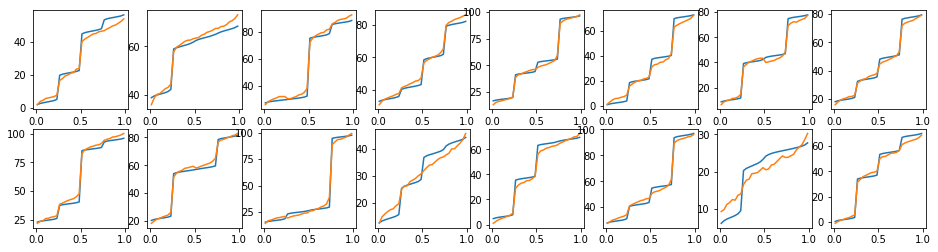

In [7]:
plt.figure(figsize=(16,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    X_test = X_train[np.random.choice(X_train.shape[0])][np.newaxis,:]
    X_test_sample = sample(np.repeat(X_test, 10000, axis=0))
    q = np.linspace(0, 1, num=32, endpoint=False) + 0.5/32
    plt.plot(q, np.quantile(X_test_sample, q))
    plt.plot(q, M.predict(X_test)[0])
plt.show()